In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
docWord = np.load("science2k-doc-word.npy")


### k-means
1. Select k points as means
2. Assign each point to its closest center
3. Compute clusters centers
4. Repeat 2-4

In [65]:
def assignPointsToClusters(points, clustersCenters, k):
    assignment = np.empty(points.shape[0])
    withinDist = 0
    for i in range(points.shape[0]):
        minDist = np.infty
        for cluster in range(k):
            dist = np.linalg.norm(points[i] - clustersCenters[cluster])
            if dist < minDist:
                minDist = dist
                bestCluster = cluster
        assignment[i] = bestCluster
        withinDist += minDist
    return assignment, withinDist

def computeClustersCenters(points, assignment, k):
    clustersCenters = np.empty((k,points.shape[1]))
    for cluster in range(k):
        center = np.mean(points[assignment == cluster], axis=0)
        clustersCenters[cluster] = center
    return clustersCenters

def kMeans(points, k, n_iter):
    withinDists = np.empty(n_iter)
    for i in range(n_iter):
        clustersCenters = points[np.random.randint(0,points.shape[0],k)]
        withinDist = 0
        oldWithinDist = -1
        while withinDist != oldWithinDist:
            oldWithinDist = withinDist
            assignment, withinDist = assignPointsToClusters(points, clustersCenters, k)
            clustersCenters = computeClustersCenters(points, assignment, k)
            print('W'+str(i)+' = ' + str(round(withinDist,5)), end='\r')
        withinDists[i] = withinDist
    minWithinDist = np.min(withinDists)
    stdWithinDist = np.std(withinDists)
    return minWithinDist, stdWithinDist

for k in range(2,21):
    print('k = '+str(k))
    minWithinDist, std = kMeans(docWord, k, n_iter=6)
    print('W = '+str(minWithinDist))
    print('CI=['+str(minWithinDist-std)+' - '+str(minWithinDist+std)+']')


k = 2
W = 211654.63070204828
CI=[211602.99509941653 - 211706.26630468003]
k = 3


KeyboardInterrupt: 

We will choose k=9 moving forward, because it achieved a reasonable within-cluster distance compared to higher k's while being probably easier to interpret (smaller number of clusters).

In [66]:
kMeans(docWord, 10, n_iter=6)

KeyboardInterrupt: 

In [7]:
kMeans_algo = KMeans()
k_grid = {'n_clusters': np.arange(2,21)}
k_grid_cv = GridSearchCV(kMeans_algo, k_grid, cv=5, n_jobs=-1)
k_grid_cv.fit(docWord, y=None)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])})

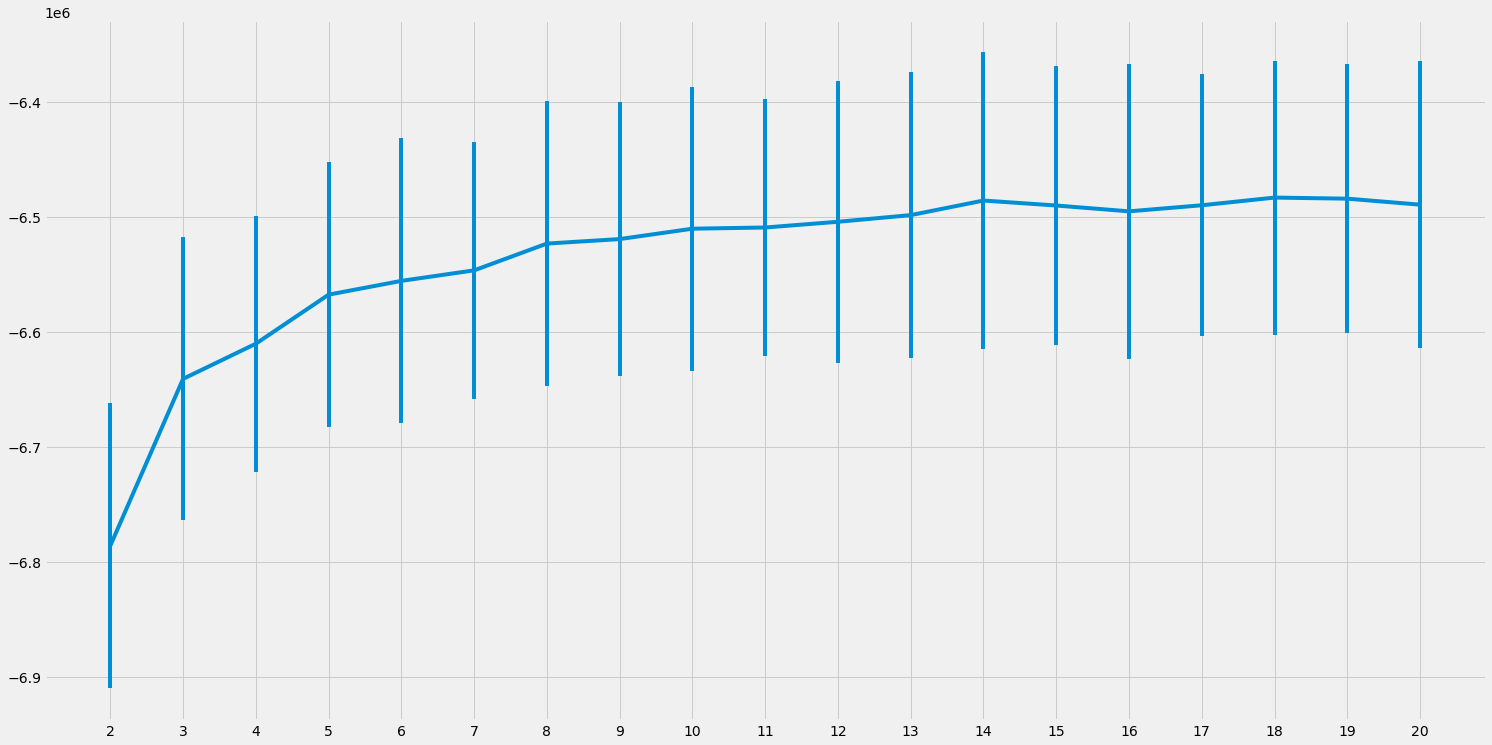

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[23,12])
k_grid_results = pd.DataFrame(k_grid_cv.cv_results_)
plt.errorbar(np.arange(2,21), k_grid_results['mean_test_score'], yerr=k_grid_results['std_test_score'])
plt.grid(True)
# plt.yticks(np.arange(-6.9e6, -6.3e6, 0.05e6))
plt.xticks(np.arange(2,21));

In [9]:
kmax = 20
sil = []
iner = []
for k in range(2, kmax+1):
  kmeansmodel = KMeans(n_clusters = k).fit(docWord)
  labels = kmeansmodel.labels_
  inertia = kmeansmodel.inertia_
  sil.append(silhouette_score(docWord, labels, metric = 'euclidean'))
  iner.append(kmeansmodel.inertia_)

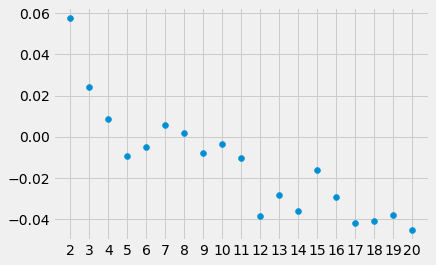

In [10]:
plt.scatter(np.arange(2,21), sil)
plt.grid(True)
plt.xticks(np.arange(2,21));

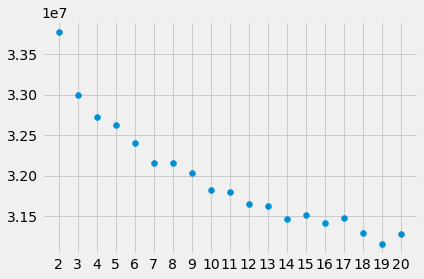

In [11]:
plt.scatter(np.arange(2,21), iner)
plt.grid(True)
plt.xticks(np.arange(2,21));

It's not immediately clear which k value is optimal due to the lack of elbows in the inertia plot or silhouette peaks. However, a k value of 7 appears to form a slight elbow, a local silhouette peak, and somewhat comparable results to cross validation (which returned an optimal k of 5). We shall proceed with this value.

In [15]:
x_mean = pd.DataFrame(docWord).describe().loc['mean']

In [18]:
selected_kmeans = KMeans(n_clusters=7).fit(docWord)
labels = selected_kmeans.labels_
cluster_centers = selected_kmeans.cluster_centers_

In [20]:
pd.DataFrame(cluster_centers)

,0,1,2,3,4,5,6,7,8,9,...,5466,5467,5468,5469,5470,5471,5472,5473,5474,5475
0,-1.075192,-1.075192,11.130890,8.135249,8.828346,-1.075192,9.051480,-1.075192,8.540680,8.828346,...,-1.075192,-1.075192,-1.075192,-1.075192,-1.075192,-1.075192,-1.075192,-1.075192,-1.075192,-1.075192
1,1.510256,2.002139,8.693427,5.513734,8.738847,2.066622,3.767423,1.667289,4.104493,8.287544,...,-0.313367,-0.277276,-0.364566,-0.367503,-0.344193,-0.263621,-0.385548,-0.275808,-0.385548,-0.385548
2,6.153745,8.408317,9.208793,9.580204,9.245519,10.208587,7.297410,9.897632,7.051815,8.824523,...,-1.476792,-0.625053,-1.476792,-1.476792,-1.476792,-1.476792,-1.476792,0.548542,-1.476792,-1.476792
3,10.325978,8.596832,9.147930,8.366597,9.112234,8.575021,6.503129,7.989197,5.306220,8.932781,...,-0.460360,-0.041618,-0.758833,-0.758833,-0.710130,-0.635511,-0.646873,-0.614629,-0.565405,-0.758833
4,9.589376,0.037293,9.204179,8.140402,9.086948,0.296373,8.709505,-0.512138,8.184380,8.889176,...,-0.659492,-0.706009,-0.792044,-0.442758,-0.792044,-0.702509,-0.792044,-0.604846,-0.792044,-0.792044
5,10.196054,0.796022,9.008962,8.728830,9.054800,2.333007,5.988765,0.643948,5.685264,8.793609,...,-0.423891,-0.737094,-0.392307,-0.737094,-0.128101,-0.737094,-0.737094,-0.650623,-0.737094,-0.288155
6,-0.262196,2.584945,9.501370,6.947531,8.902501,2.451116,4.877264,1.456578,7.196312,8.588631,...,-0.656846,-0.656846,-0.721864,-0.721864,-0.656846,-0.591828,-0.721864,-0.721864,-0.721864,-0.721864


In [27]:
subtracted = cluster_centers - x_mean.to_numpy()

In [28]:
pd.DataFrame(subtracted)

,0,1,2,3,4,5,6,7,8,9,...,5466,5467,5468,5469,5470,5471,5472,5473,5474,5475
0,-7.196773,-4.469287,2.115423,0.856759,-0.124394,-4.743906,3.391918,-3.995218,2.982730,0.177337,...,-0.615282,-0.693260,-0.497765,-0.497656,-0.561793,-0.541010,-0.470764,-0.571192,-0.492362,-0.505496
1,-4.611325,-1.391956,-0.322040,-1.764756,-0.213892,-1.602092,-1.892139,-1.252737,-1.453457,-0.363465,...,0.146543,0.104657,0.212861,0.210034,0.169206,0.270561,0.218880,0.228193,0.197282,0.184148
2,0.032164,5.014222,0.193327,2.301714,0.292779,6.539873,1.637848,6.977606,1.493866,0.173514,...,-1.016882,-0.243120,-0.899365,-0.899256,-0.963393,-0.942610,-0.872364,1.052542,-0.893962,-0.907096
3,4.204397,5.202737,0.132464,1.088107,0.159495,4.906307,0.843567,5.069171,-0.251729,0.281772,...,-0.000451,0.340314,-0.181407,-0.181297,-0.196731,-0.101329,-0.042445,-0.110628,0.017425,-0.189137
4,3.467795,-3.356802,0.188713,0.861912,0.134208,-3.372341,3.049943,-3.432163,2.626430,0.238167,...,-0.199582,-0.324077,-0.214617,0.134778,-0.278645,-0.168327,-0.187616,-0.100846,-0.209214,-0.222348
5,4.074473,-2.598073,-0.006504,1.450340,0.102060,-1.335707,0.329203,-2.276078,0.127315,0.142600,...,0.036019,-0.355161,0.185120,-0.159558,0.385298,-0.202912,-0.132666,-0.146623,-0.154264,0.281541
6,-6.383777,-0.809150,0.485904,-0.330959,-0.050239,-1.217598,-0.782298,-1.463448,1.638362,-0.062378,...,-0.196936,-0.274914,-0.144438,-0.144328,-0.143447,-0.057646,-0.117436,-0.217864,-0.139034,-0.152168


In [29]:
x_mean

0       6.121581
1       3.394095
2       9.015467
3       7.278490
4       8.952740
          ...   
5471   -0.534182
5472   -0.604428
5473   -0.504000
5474   -0.582830
5475   -0.569696
Name: mean, Length: 5476, dtype: float64